# Identificar Perfil de Consumo de Clientes de uma Instituição Financeira

## Uma breve introdução

Uma Instituição Financeira X tem o interesse em identificar o perfil de gastos dos seus clientes. Identificando os clientes certos, eles podem melhorar a comunicação dos ativos promocionais, utilizar com mais eficiência os canais de comunicação e aumentar o engajamento dos clientes com o uso do seu produto.

## Sobre o estudo

Os dados estão anonimizados por questões de segurança. No dataset, temos o valor gasto de 121818 clientes, no ano de 2019, em cada ramo de atividade. A base já está limpa. O intuito aqui é apresentar uma possibilidade de fazer a clusterização de clientes com base em seu consumo. Os dados são de 1 ano a fim de diminuir o efeito da sazonalidade.

## Importando a biblioteca

Será necessário instalar o pacote kmodes, caso não tenha. 

In [ ]:
# pip install --upgrade kmodes

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import plotly.express as px
# pacote do modelo
from kmodes.kmodes import KModes
# from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

random.seed(2020)

pd.options.display.float_format = '{:,.2f}'.format

## Leitura dos dados

In [2]:
# Carregar os dados
dados = pd.read_csv('../../dados_gasto_rmat.csv', sep=',')

In [3]:
dados.head(10)

,CLIENTE,RMAT,VALOR_GASTO
0,92442,animais / comidas e suprimentos,1663.50
1,92442,armarinhos / tecidos,21.97
2,92442,artigos eletronicos,62.60
3,92442,bares / boates / casas noturnas,94.00
4,92442,comidas congeladas,423.25
5,92442,conveniencia / delicatessens / rotisserie / ca...,80.45
6,92442,cosmeticos / perfumarias e toucadores,129.90
7,92442,drogarias e farmacias,590.17
8,92442,entretenimento,39.50
9,92442,fast food,102.00


In [4]:
print('O arquivo possui ' + str(dados.shape[0]) + ' linhas e ' + str(dados.shape[1]) + ' colunas.')

O arquivo possui 3898614 linhas e 3 colunas.


In [5]:
# Tipos dos dados
dados.dtypes

CLIENTE          int64
RMAT            object
VALOR_GASTO    float64
dtype: object

In [6]:
# Verificando valores nulos
dados.isnull().values.any()

False

A base não possui valores nulos.

## Visualização dos dados

In [7]:
# Total de clientes
len(dados['CLIENTE'].unique())

121818

Soma do valor gasto em cada ramo de atividade.

In [12]:
# Dados agregados por RMAT e o percentual gasto
dados_agreg = dados.groupby(['RMAT'])['VALOR_GASTO'].sum().reset_index()
dados_agreg['percentual'] = round(dados_agreg['VALOR_GASTO']/sum(dados_agreg['VALOR_GASTO'])*100,2)
dados_agreg.head()

,RMAT,VALOR_GASTO,percentual
0,acessorios femininos,"12,819,497.31",0.33
1,agencias de turismo,"74,480,215.78",1.91
2,agentes mobiliarios / corretores,"14,428,502.62",0.37
3,aluguel de barcos,"25,145.51",0.00
4,aluguel de carros,"42,925,425.17",1.10


In [13]:
# Traz o 30 RMATs que tiveram maior gasto dos clientes
top_rotulos = dados_agreg.sort_values(by = 'percentual', ascending = False)[:30]

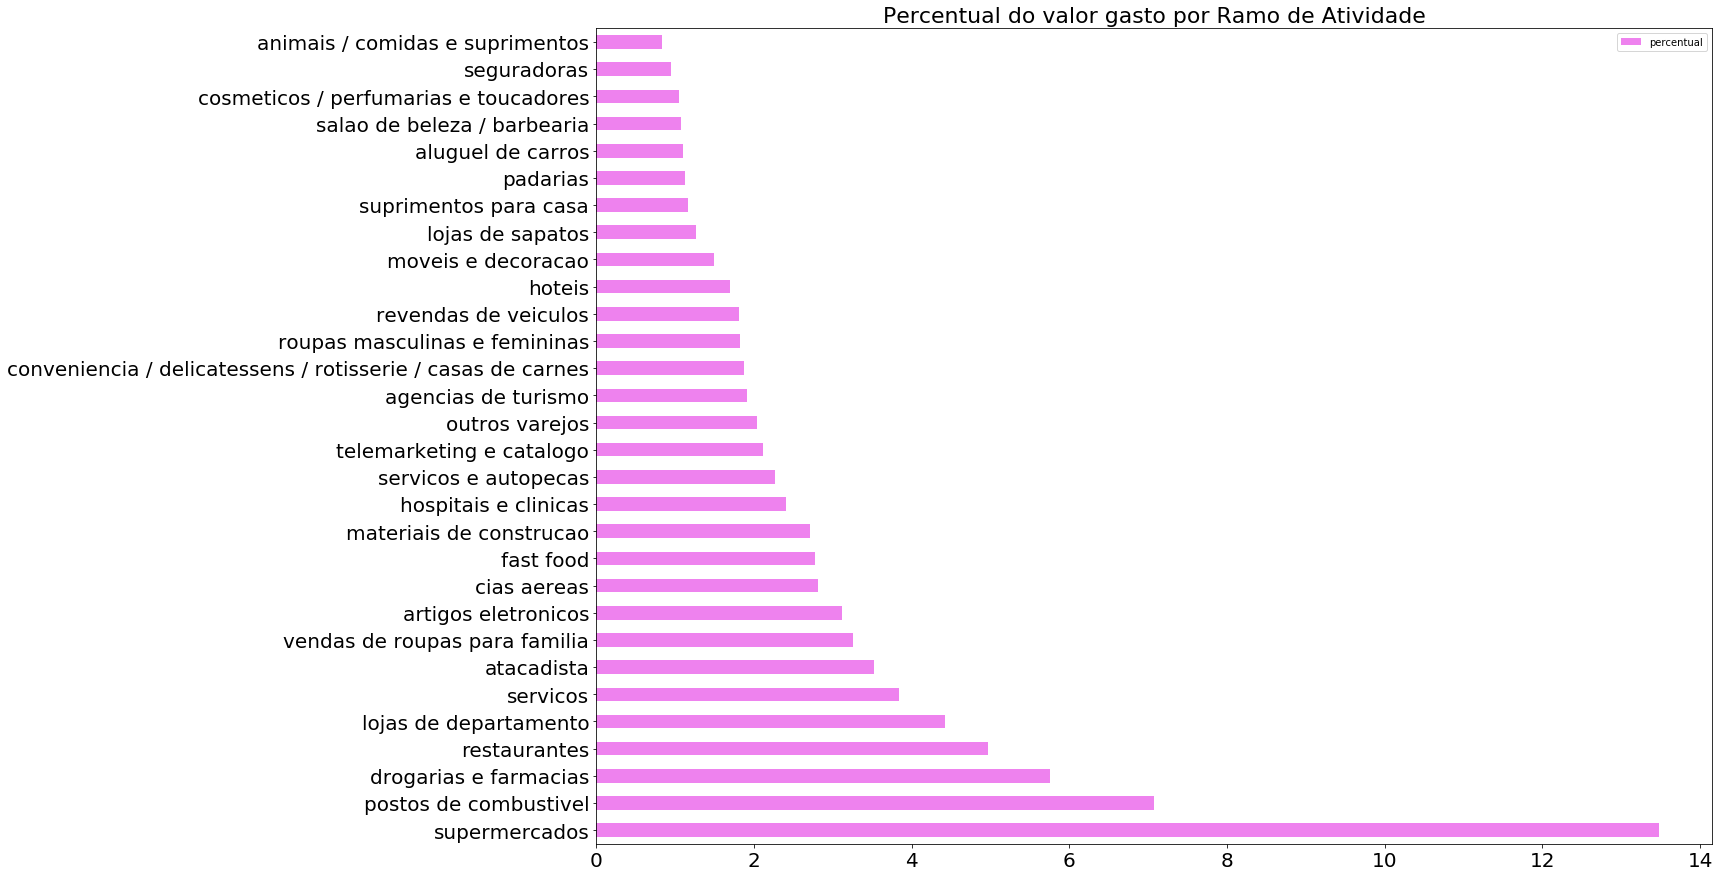

In [14]:
# Gráfico dos RMATs
ax = top_rotulos.plot.barh(x='RMAT', y='percentual', rot=0, figsize = (20, 15), fontsize=20, color='violet')
plt.title('Percentual do valor gasto por Ramo de Atividade', fontsize=22)
plt.xlabel('')
plt.ylabel('')
plt.show()

Supermercados, postos de combustível e drogarias são os ramos com maior consumo dos clientes, representando 13.48%, 7.07% e 5.75%, respectivamente. 

### Construção da base para o modelo

Vamos construir uma base que seja a nível cliente e as colunas serão os percentuais de consumo em cada ramo de atividade. Aqui, temos muitos percentuais 0 em determinados ramos de atividade e isso tem impacto negativo na construção do modelo. Portanto, iremos categorizar as variáveis de acordo com a variação do percentual para cada atributo.

In [15]:
dados.head()

,CLIENTE,RMAT,VALOR_GASTO
0,92442,animais / comidas e suprimentos,"1,663.50"
1,92442,armarinhos / tecidos,21.97
2,92442,artigos eletronicos,62.60
3,92442,bares / boates / casas noturnas,94.00
4,92442,comidas congeladas,423.25


A função pivot faz a transposição dos dados, transformando o valor de "RMAT" em colunas.

In [16]:
# Inverter o data frame (colocar nos rmats como coluna)
cli_pivot = dados.pivot(index='CLIENTE', columns='RMAT', values='VALOR_GASTO')
cli_pivot.fillna(0, inplace = True)

In [17]:
# Calcular o percentual de volume transacionado de cada cliente por rmat 
cli_pivot = cli_pivot.apply(lambda x: x.apply(lambda y: 100*y/sum(x)),axis = 1)
cli_pivot.head()

RMAT,acessorios femininos,agencias de turismo,agentes mobiliarios / corretores,aluguel de barcos,aluguel de carros,animais / comidas e suprimentos,armarinhos / tecidos,artigos eletronicos,atacadista,bares / boates / casas noturnas,...,servicos de tv a cabo e outros,servicos e autopecas,supermercados,suprimentos para casa,telemarketing e catalogo,transporte,universidades,utensilios domesticos,vendas de roupas para familia,vestuario
CLIENTE,,,,,,,,,,,,,,,,,,,,,
9,0.04,0.00,0.00,0.00,0.66,4.34,0.03,11.09,3.32,0.00,...,1.60,5.71,18.93,0.00,0.48,0.00,0.00,8.47,1.56,0.00
10,0.00,0.00,0.00,0.00,0.00,7.63,0.23,0.50,7.93,0.00,...,0.16,0.00,27.27,0.00,0.29,0.00,0.00,0.00,1.03,0.14
12,0.00,0.00,0.62,0.00,0.00,0.08,0.00,1.36,8.95,3.36,...,0.00,7.59,17.56,0.00,2.55,0.00,0.00,0.00,0.93,0.00
15,0.00,0.00,0.00,0.00,0.00,0.00,1.04,4.45,0.00,2.74,...,0.00,0.00,33.22,0.02,1.07,0.00,0.00,0.00,0.00,1.92
19,0.97,0.00,0.00,0.00,2.33,0.00,0.00,4.86,0.87,5.03,...,1.61,0.00,12.29,0.00,1.54,0.00,0.00,0.09,3.06,0.00


Abaixo, uma função que quebra os valores de cada coluna em quantidade de categorias escolhido. Nesse caso, utilizamos 8 quebras.

In [19]:
# Funnção para fazer categorização das variaveis
def hcut(df, colunas, nlevs, prefixo=''):
    x = df.copy()
    for c in colunas:
        
        x[prefixo+c] = pd.cut(x[c] , bins=nlevs, include_lowest = False, precision=0)
    
    return x

In [20]:
base_cluster = hcut(cli_pivot, cli_pivot
                    .columns, 8, 'esc_')

In [21]:
base_cluster.head()

RMAT,acessorios femininos,agencias de turismo,agentes mobiliarios / corretores,aluguel de barcos,aluguel de carros,animais / comidas e suprimentos,armarinhos / tecidos,artigos eletronicos,atacadista,bares / boates / casas noturnas,...,esc_servicos de tv a cabo e outros,esc_servicos e autopecas,esc_supermercados,esc_suprimentos para casa,esc_telemarketing e catalogo,esc_transporte,esc_universidades,esc_utensilios domesticos,esc_vendas de roupas para familia,esc_vestuario
CLIENTE,,,,,,,,,,,,,,,,,,,,,
9,0.04,0.00,0.00,0.00,0.66,4.34,0.03,11.09,3.32,0.00,...,"(-0.1, 9.0]","(-0.1, 10.0]","(12.0, 25.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
10,0.00,0.00,0.00,0.00,0.00,7.63,0.23,0.50,7.93,0.00,...,"(-0.1, 9.0]","(-0.1, 10.0]","(25.0, 38.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
12,0.00,0.00,0.62,0.00,0.00,0.08,0.00,1.36,8.95,3.36,...,"(-0.1, 9.0]","(-0.1, 10.0]","(12.0, 25.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
15,0.00,0.00,0.00,0.00,0.00,0.00,1.04,4.45,0.00,2.74,...,"(-0.1, 9.0]","(-0.1, 10.0]","(25.0, 38.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
19,0.97,0.00,0.00,0.00,2.33,0.00,0.00,4.86,0.87,5.03,...,"(-0.1, 9.0]","(-0.1, 10.0]","(-0.0, 12.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"


Agora, filtraremos as variáveis necessárias para a modelagem. 

In [22]:
# Selecionar somentes as colunas categorizadas que serão utilizadas no modelo
filter_col = [col for col in base_cluster if
              col.startswith('esc_')]
df1 = base_cluster.loc[:,filter_col].reset_index() 
df1.head()

RMAT,CLIENTE,esc_acessorios femininos,esc_agencias de turismo,esc_agentes mobiliarios / corretores,esc_aluguel de barcos,esc_aluguel de carros,esc_animais / comidas e suprimentos,esc_armarinhos / tecidos,esc_artigos eletronicos,esc_atacadista,...,esc_servicos de tv a cabo e outros,esc_servicos e autopecas,esc_supermercados,esc_suprimentos para casa,esc_telemarketing e catalogo,esc_transporte,esc_universidades,esc_utensilios domesticos,esc_vendas de roupas para familia,esc_vestuario
0,9,"(-0.1, 7.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.01, 1.0]","(-0.0, 12.0]","(-0.1, 11.0]","(-0.1, 8.0]","(-0.0, 12.0]","(-0.1, 12.0]",...,"(-0.1, 9.0]","(-0.1, 10.0]","(12.0, 25.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
1,10,"(-0.1, 7.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.01, 1.0]","(-0.0, 12.0]","(-0.1, 11.0]","(-0.1, 8.0]","(-0.0, 12.0]","(-0.1, 12.0]",...,"(-0.1, 9.0]","(-0.1, 10.0]","(25.0, 38.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
2,12,"(-0.1, 7.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.01, 1.0]","(-0.0, 12.0]","(-0.1, 11.0]","(-0.1, 8.0]","(-0.0, 12.0]","(-0.1, 12.0]",...,"(-0.1, 9.0]","(-0.1, 10.0]","(12.0, 25.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
3,15,"(-0.1, 7.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.01, 1.0]","(-0.0, 12.0]","(-0.1, 11.0]","(-0.1, 8.0]","(-0.0, 12.0]","(-0.1, 12.0]",...,"(-0.1, 9.0]","(-0.1, 10.0]","(25.0, 38.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"
4,19,"(-0.1, 7.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.01, 1.0]","(-0.0, 12.0]","(-0.1, 11.0]","(-0.1, 8.0]","(-0.0, 12.0]","(-0.1, 12.0]",...,"(-0.1, 9.0]","(-0.1, 10.0]","(-0.0, 12.0]","(-0.1, 12.0]","(-0.0, 12.0]","(-0.004, 0.5]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 11.0]","(-0.1, 7.0]"


### Criação do modelo 

Para nosso caso, utilizaremos o método de clusterização chamado K-modes. Esse método é uma extensão do K-means. Em vez de distâncias, ele usa dissimilaridade (isto é, quantificação das incompatibilidades totais entre dois objetos: quanto menor esse número, masi semelhantes são os dois objetos). Além disso, ele utiliza modas. Cada vetor de elementos é criado de forma a minimizar as diferenças entre o próprio vetor e cada objetos dos dados. Assim, teremos tantos vetores de modas quanto o número de clusters necessários, pois eles atuam como centróides. 


Aqui, iremos fazer a divisão dos clientes em 7 clusters. 

In [23]:
km_huang = KModes(n_clusters=7, init = "Huang", n_init = 5, verbose=1, random_state=2020)
fitClusters = km_huang.fit_predict(df1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37911, cost: 285526.0
Run 1, iteration: 2/100, moves: 6829, cost: 285526.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 24674, cost: 296153.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 38186, cost: 311798.0
Run 3, iteration: 2/100, moves: 1175, cost: 311797.0
Run 3, iteration: 3/100, moves: 0, cost: 311797.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 49330, cost: 291921.0
Run 4, iteration: 2/100, moves: 5319, cost: 291920.0
Run 4, iteration: 3/100, moves: 0, cost: 291920.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 35294, cost: 289461.0
Run 5, iteration: 2/100, moves: 14295, cost: 289460.0
Run 5, iteration:

In [24]:
# Adiciona os clusters na base
df1['cluster'] = fitClusters
base_cluster['cluster'] = fitClusters

#### Percentual de clientes por cluster. 

In [59]:
df1['cluster'].value_counts()/len(df1)*100

5   32.09
2   25.20
0   18.73
4    9.64
1    5.72
6    4.64
3    3.98
Name: cluster, dtype: float64

In [41]:
df2 = base_cluster.drop(columns=filter_col)

In [42]:
df2.head()

RMAT,acessorios femininos,agencias de turismo,agentes mobiliarios / corretores,aluguel de barcos,aluguel de carros,animais / comidas e suprimentos,armarinhos / tecidos,artigos eletronicos,atacadista,bares / boates / casas noturnas,...,servicos e autopecas,supermercados,suprimentos para casa,telemarketing e catalogo,transporte,universidades,utensilios domesticos,vendas de roupas para familia,vestuario,cluster
CLIENTE,,,,,,,,,,,,,,,,,,,,,
9,0.04,0.00,0.00,0.00,0.66,4.34,0.03,11.09,3.32,0.00,...,5.71,18.93,0.00,0.48,0.00,0.00,8.47,1.56,0.00,2
10,0.00,0.00,0.00,0.00,0.00,7.63,0.23,0.50,7.93,0.00,...,0.00,27.27,0.00,0.29,0.00,0.00,0.00,1.03,0.14,4
12,0.00,0.00,0.62,0.00,0.00,0.08,0.00,1.36,8.95,3.36,...,7.59,17.56,0.00,2.55,0.00,0.00,0.00,0.93,0.00,2
15,0.00,0.00,0.00,0.00,0.00,0.00,1.04,4.45,0.00,2.74,...,0.00,33.22,0.02,1.07,0.00,0.00,0.00,0.00,1.92,4
19,0.97,0.00,0.00,0.00,2.33,0.00,0.00,4.86,0.87,5.03,...,0.00,12.29,0.00,1.54,0.00,0.00,0.09,3.06,0.00,5


In [60]:
# Para visualização dos clusters

# from sklearn.decomposition import PCA
# pca_2 = PCA(2)
# plot_columns = pca_2.fit_transform(base_cluster.iloc[:,0:65])
# plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=fitClusters,)
# plt.show()